In [1]:
__author__ = 'Knut Olsen <kolsen@noao.edu>, Robert Nikutta <rnikutta@noao.edu>'
__version__ = '20190102' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['des_dr1']
__keywords__ = ['dwarf galaxies','convolution','WCS','SIA']

# Dwarf galaxies in DES DR1
*Knut Olsen, Robert Nikutta & NOAO Data Lab Team*

### Table of contents
* [Imports & setup](#import)
* [Coordinate resolution and querying for photometry](#photometry)
* [The dwarf filter](#dwarffilter)
* [Retrieve images via SIA service](#sia)
* [Resources and references](#resources)

# Goals
* Resolve spatial coordinates of known dwarf companions of the Milky Way
* Query DES DR1 for stars around these positions
* Construct a WCS for each query and plot the spatial distribution of stars
* Apply spatial filtering techniques to detect stellar overdensities
* Retrieve and display image cutouts

# Summary
In this notebook, we demonstrate the discovery of faint Milky Way dwarf companions in DES DR1.  We query the database around the positions of known dwarfs and apply filtering techniques to reveal the dwarfs as spatial overdensities of filtered sources.

**Background**
Ultrafaint dwarf galaxies are crucial to understanding many aspects of the universe. For instance, they are dominated by dark matter; their localization in space can thus trace the large-scale structure of the dark matter distribution. Furthermore, dwarf galaxies are suspected to host intermediate-mass black holes (IMBH), which so far have eluded efforts to find them. IMBHs will naturally bridge the gap between the solar-mass black hole and super-massive blackholes that reside at the center of virtually every large galaxy.

**Data retrieval**
We will retrieve stars and images around the locations of seven dwarf galaxies found in the DES DR1 catalog.

**Detection**
We will convolve the spatial distribution of our dataset with a pair of Gaussian kernels and subtract the results, as done in e.g. [Stanford et al. (2005, ApJ, 634, 2, L129)](http://adsabs.harvard.edu/abs/2005ApJ...634L.129S) (galaxy clusters), or [Koposov et al. (2008, ApJ, 686, 279)](http://adsabs.harvard.edu/abs/2008ApJ...686..279K) (MW satellites). This has the effect of convolving the spatial distribution with a Mexican hat filter, which is useful for detecting objects at a desired spatial scale.

# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/known-issues.php

<a class="anchor" id="import"></a>
# Imports and initialization
Import relevant modules and set up URL for SIA image retrieval.

In [2]:
# std lib
from collections import OrderedDict

# 3rd party
import numpy as np
import pylab as plt
from astropy import utils, io, convolution, wcs
from astropy.visualization import make_lupton_rgb
from astropy.coordinates import name_resolve
from pyvo.dal import sia
%matplotlib inline

# Data Lab
from dl import queryClient as qc
from dl.helpers.utils import convert

# set up Simple Image Access (SIA) service
DEF_ACCESS_URL = "http://datalab.noao.edu/sia/des_dr1"
svc = sia.SIAService(DEF_ACCESS_URL)

<a class="anchor" id="photometry"></a>
# Coordinates and photometry data around dwarfs
We resolve the positions of seven dwarf galaxies and query the database for stars around them.

In [3]:
# Dwarf names from Bechtol et al. (2015)
names = ['Ret II','Eri II','Tuc II','Hor I','Pic I','Phe II','Eri III']

radius = 1. # search radius in degrees

# columns to query for
columns = '''ra,dec,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,flags_g,flags_i,flags_r,flags_z,
    flux_auto_g,fluxerr_auto_g,flux_auto_i,fluxerr_auto_i,spread_model_g,spread_model_i,
    spread_model_r,spread_model_z,class_star_g,class_star_i,class_star_r,class_star_z,
    kron_radius,tilename'''

In [4]:
# a function to retrieve data around a point in the sky
def getData(ra,dec,radius=1.0,columns='*'):

    query_template =\
    """SELECT {0} FROM des_dr1.main
       WHERE q3c_radial_query(ra,dec,{1},{2},{3})"""

    query = query_template.format(columns,ra,dec,radius)
    
    try:
        result = qc.query(sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = convert(result,'pandas')
    
    return df

# gets coordinates of a named source
def resolve_coordinates(name):
    try:
        coords = name_resolve.get_icrs_coordinates(name)
    except Exception as e:
        raise

    ra = coords.ra.to('deg').value
    dec = coords.dec.to('deg').value      

    return coords, ra, dec

In [5]:
dgs = OrderedDict([(name,dict()) for name in names]) # empty dictionary of dictionaries

# loop over dwarfs, resolving coordinates and querying for photometry data
for j,name in enumerate(dgs.keys()):
    print('{:s}: resolving coordinates and querying for data'.format(name))
    coords, ra0, dec0 = resolve_coordinates(name)
    dgs[name]['ra0'] = ra0
    dgs[name]['dec0'] = dec0
    df = getData(ra0,dec0,radius=radius,columns=columns)
    dgs[name]['df'] = df
print("Done.")

Ret II: resolving coordinates and querying for data
Eri II: resolving coordinates and querying for data
Tuc II: resolving coordinates and querying for data
Hor I: resolving coordinates and querying for data
Pic I: resolving coordinates and querying for data
Phe II: resolving coordinates and querying for data
Eri III: resolving coordinates and querying for data
Done.


<a class="anchor" id="dwarffilter"></a>
# Filtering and plotting the dwarfs
We filter the photometry to include objects without SE flags, with S/N>10, that are point-like (using SPREAD_MODEL, CLASS_STAR, and KRON_RADIUS--see the notebook StarGalQsoDESDR1 for details), and that are relatively blue (*g-i* < 1.0).  We convolve the result with the spatial filter (defined below).

Some helper functions first:

In [6]:
# create a proper WCS object
def get_wcs(ra,dec,image,fov=1.,unit='deg',projection=("RA---TAN","DEC--TAN")):
    npix = image.shape[0]
    crpix = npix/2 + 1
    cdelt = fov/float(npix)
    w = wcs.WCS(naxis=2)
    w.wcs.cunit = (unit,unit)
    w.wcs.crpix = (crpix,crpix)
    w.wcs.cdelt = np.array((-cdelt,cdelt))
    w.wcs.ctype = projection
    w.wcs.crval = (ra,dec) #coords.ra.to(unit).value, coords.dec.to(unit).value)
    return w

# a spatial convolution filter
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    """Differential convolution with 2D Gaussian kernels.
    
       Based on Koposov et al. (2008).
       Code by Ken Mighell and Mike Fitzpatrick.
       Minor edits by RN.
       
       Parameters
       ----------
       ra, dec : float or array
           RA & Dec in degrees.
    
       fwhm_small, fwhm_big : float
           Full-width half maximum sizes of the small and big Gaussian kernels
           to use in convolution, in arcminutes.
    """
    
    x, y = ra, dec

    print("Computing differential convolution")

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max()) / 2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint(xdiff_angular_arcmin).astype('int')
    ny = np.rint(ydiff_arcmin).astype('int')

    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve(raw_hist, kernel_big)
    conv_small = convolution.convolve(raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean(delta, dtype='float64')
    sigma = np.std(delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median(delta) # not used
    floor = mean

    clipped = delta.copy()
    clipped[delta < floor] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

Now let's run the dwarf filter on every retrieved field and plot the resulting convolved spatial distributions:

    Ret II: Computing differential convolution
    Eri II: Computing differential convolution
    Tuc II: Computing differential convolution
     Hor I: Computing differential convolution
     Pic I: Computing differential convolution
    Phe II: Computing differential convolution
   Eri III: Computing differential convolution
Done.


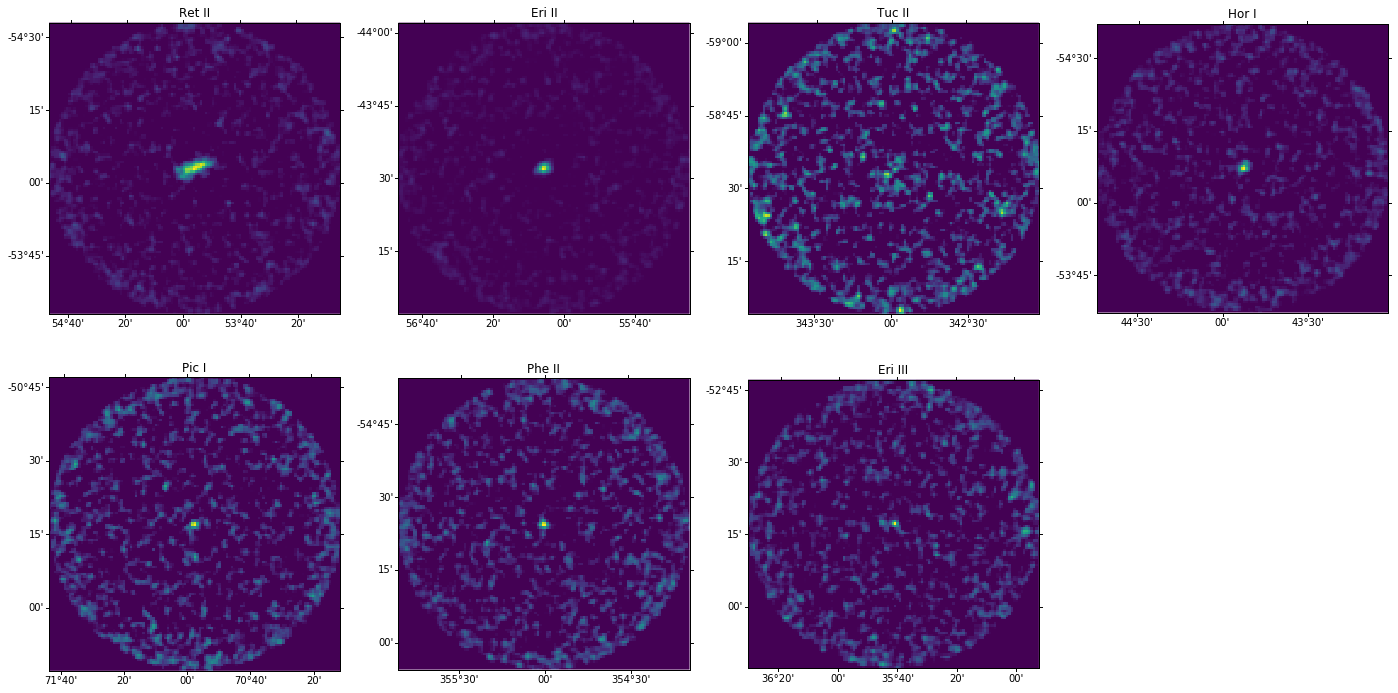

In [7]:
nrow, ncol = 2, 4  # figure layout

# common constraints
maginvalid = 90
spread = 0.01

# set up figure
fig = plt.figure(figsize=(6*ncol,6*nrow))

# loop over dwarfs
for j,name in enumerate(dgs.keys()):
    print("{:>10s}: ".format(name),end='')
    dwarf = dgs[name]
    df = dwarf['df']  # the Pandas dataframe object of current dwarf
    
    # define constraining criteria
    # (valid magnitudes, no flags, SNR>10, color range, likelihood(star) high-ish, stars fainter that gmag=18)
    keep = (df['mag_auto_g']<maginvalid) & (df['mag_auto_i']<maginvalid) &\
           (df['flags_g']==0) & (df['flags_i']==0) &\
           ((df['flux_auto_g']/df['fluxerr_auto_g'])>10) &\
           ((df['mag_auto_g']-df['mag_auto_r'])>-0.5) & ((df['mag_auto_g']-df['mag_auto_r'])<1.0) &\
           (np.abs(df['spread_model_g'])<spread) & (np.abs(df['spread_model_i'])<spread) &\
           (df['class_star_g']>0.1) & (df['kron_radius']<6) &\
           (df['mag_auto_g']>18)
           
    # apply constraints, and run the dwarf filter
    raw_hist, extent, delta, clipped, sigma = dwarf_filter(df['ra'][keep],df['dec'][keep])
    
    # construct a WCS
    w = get_wcs(dwarf['ra0'],dwarf['dec0'],clipped,fov=1.)
    
    # plot the clipped 2d histogram
    ax = fig.add_subplot(nrow,ncol,j+1,projection=w)
    im = plt.imshow(clipped)
    ax.set_title(name)
    
print("Done.")

<a class="anchor" id="sia"></a>
# Retrieve images (SIA service)
We demonstrate how to retrieve images though the SIA service for one of the dwarfs. First, define two useful helper functions: one to download the deepest available image in a given band, and one to easily plot images.

In [8]:
# download the deepest stacked images
def download_deepest_images(ra,dec,fov=0.1,bands=list('gri')):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table() #.votable #.get_first_table()
    print("The full image list contains {:d} entries.".format(len(imgTable)))
    
    sel0 = (imgTable['proctype'] == b'Stack') & (imgTable['prodtype']==b'image') # basic selection
    images = []
    for band in bands:
        print("Band {:s}: ".format(band), end='')
        sel = sel0 & (imgTable['obs_bandpass'] == band.encode()) # add 'band' to selection
        Table = imgTable[sel] # select
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print('downloading deepest stacked image...')
        img = io.fits.getdata(utils.data.download_file(url.decode(),cache=True,show_progress=False,timeout=120)) # .decode() b/c in Python 3 url is of "byte" type and getdata() expects "string" type
        images.append(img)
        
    print("Downloaded {:d} images.".format(len(images)))
    return images

# multi panel image plotter
def plot_images(images,geo=None,panelsize=5,titles=list('gri'),cmap=plt.cm.gray_r):
    if geo is None:
        geo = (len(images),1)  # ncols, nrows
        
    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=plt.mpl.colors.PowerNorm(0.1))
        ax.set_title('{:s}'.format(titles[j]))
        plt.axis('off')
    
    fig.subplots_adjust(wspace=0.05)

Let's download the deepest available image per band

In [9]:
name = 'Ret II'
fov = 0.25 # degrees
bands = list('gri')
images = download_deepest_images(dgs[name]['ra0'],dgs[name]['dec0'],fov=0.25,bands=bands)

The full image list contains 18 entries.
Band g: downloading deepest stacked image...
Band r: downloading deepest stacked image...
Band i: downloading deepest stacked image...
Downloaded 3 images.


We also compute a false-color 3-band image, and plot all images

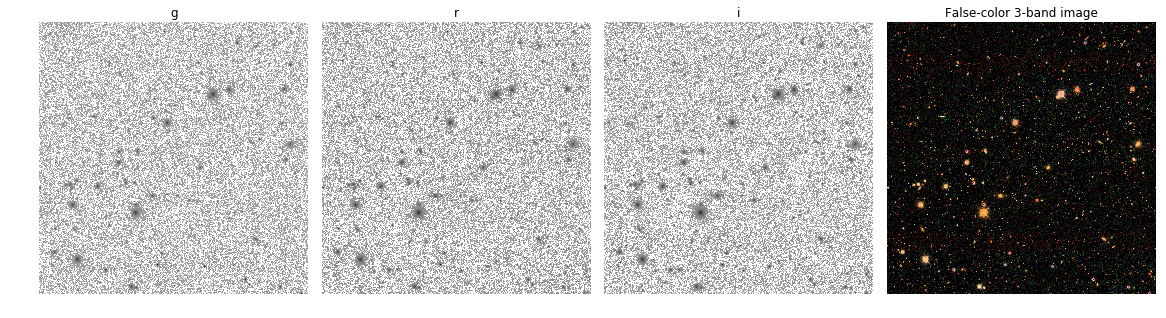

In [10]:
%%capture --no-display
images_ = [im-np.median(im) for im in images]
images_ += [make_lupton_rgb(*images[::-1],Q=3,stretch=30)] # the func expects the images in red,green,blue order
plot_images(images_,geo=(4,1),titles=bands+['False-color 3-band image'])

<a class="anchor" id="resources"></a>
## Resources and references

Bechtol, K., et al. (2015, ApJ, 807, 50) "Eight New Milky Way Companions Discovered in First-year Dark Energy Survey Data":
http://adsabs.harvard.edu/abs/2015ApJ...807...50B

Koposov et al. (2008, ApJ, 686, 279) "The Luminosity Function of the Milky Way Satellites": http://adsabs.harvard.edu/abs/2008ApJ...686..279K
